In [1]:
import sys
sys.path.append('../')
sys.path.append('/usr/local/bin')

import numpy as np
import zephyr.backend
import zephyr.middleware
import SimPEG
from pymatsolver import MumpsSolver

In [2]:
nx = 100
nz = 200
cBackground = 2500.
cAnomaly = -500.

cInitial = cBackground * np.ones((nz,nx))

cUpdate = np.zeros((nz,nx))
cUpdate[(nz/2)-10:(nz/2)+10,(nx/2)-10:(nx/2)+10] = cAnomaly

cTrue = cInitial + cUpdate

sz = np.arange(25, nz-24, 1)
sx = 25. * np.ones((len(sz),))
rz = np.arange(25, nz-24, 1)
rx = (nx - 25.) * np.ones((len(rz),))

geom = {
    'src':      np.vstack([sx, sz]).T,
    'rec':      np.vstack([rx, rz]).T,
}

systemConfig = {
    'dx':       1.,                             # m
    'dz':       1.,                             # m
    'c':        cTrue.ravel(),                  # m/s
    'rho':      1.,                             # kg/m^3
    'nx':       nx,                             # count
    'nz':       nz,                             # count
    'freqs':    np.arange(50, 450, 50),         # Hz
    'Disc':     zephyr.backend.MiniZephyrHD,    # discretization
    'geom':     geom,                           # dictionary
    'nWorkers': 8,
    'Solver':   MumpsSolver,
    'targetGPW':8,
    'cMin':     2000.,
}

In [3]:
problem = zephyr.middleware.Helm2DViscoProblem(systemConfig)
survey  = zephyr.middleware.Helm2DSurvey(systemConfig)
problem.pair(survey)

In [4]:
%%time
dObs = survey.dpred()

CPU times: user 699 ms, sys: 635 ms, total: 1.33 s
Wall time: 3.85 s


In [5]:
survey.dobs = dObs
survey.std = 1.

dmisfit = SimPEG.DataMisfit.l2_DataMisfit(survey)
dmisfit.Wd = 1.

opt = SimPEG.Optimization.ProjectedGradient()
reg = zephyr.middleware.HelmBaseRegularization(problem.mesh)

invProb = SimPEG.InvProblem.BaseInvProblem(dmisfit, reg, opt)
inv = SimPEG.Inversion.BaseInversion(invProb)

In [6]:
# mOpt = inv.run(cInitial.ravel())

In [7]:
import scipy.optimize

In [8]:
# misfit = lambda x: invProb.evalFunction(x, True, False)
# res = scipy.optimize.minimize(misfit, cInitial.ravel(), jac=True, method='Newton-CG')
res = scipy.optimize.minimize(dmisfit.eval, cInitial.ravel(), jac=dmisfit.evalDeriv, method='Newton-CG')

/usr/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:164: ComplexWarning: Casting complex values to real discards the imaginary part
  amin, amax, isave, dsave)
/usr/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:414: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 0] = dc ** 2
/usr/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:415: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/usr/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 0] = -dc ** 3
/usr/lib/python2.7/dist-packages/scipy/optimize/linesearch.py:417: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<matplotlib.colorbar.Colorbar instance at 0x7f9d0dae88c0>

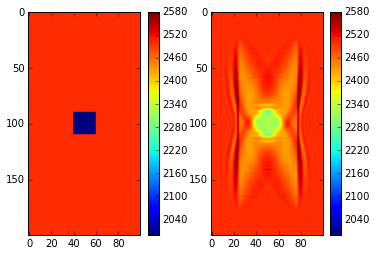

In [9]:
import matplotlib.pyplot as plt
%pylab inline

plotOpts = {
    'vmin': min(cTrue.min(), res.x.min()),
    'vmax': max(cTrue.max(), res.x.max()),
}

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(cTrue, **plotOpts)
plt.colorbar()

fig.add_subplot(1,2,2)
plt.imshow(res.x.reshape((nz,nx)), **plotOpts)
plt.colorbar()